In [1]:
##################
## Working Code ##
##################

import os
import numpy as np
import cv2
import gc
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from keras._tf_keras.keras.applications import ResNet50
from keras._tf_keras.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.preprocessing.image import img_to_array
from keras._tf_keras.keras.utils import to_categorical

from transformers import ViTImageProcessor, TFViTModel

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import platform




/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Detect Apple Silicon and force CPU usage for TensorFlow if needed
if platform.machine() == "arm64" and platform.system() == "Darwin":
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    tf.config.set_visible_devices([], 'GPU')
    
# ------------------ CONFIG ------------------
IMAGE_SIZE = (224, 224)
DATASET_DIR = 'Data_disease'
TRAIN_DIR = os.path.join(DATASET_DIR, 'Train')
TEST_DIR = os.path.join(DATASET_DIR, 'Validation')


In [3]:

# ------------------ LOAD IMAGES ------------------
def load_dataset(directory, preprocess_func=None, class_map=None):
    X, y = [], []
    class_names = sorted(os.listdir(directory)) if class_map is None else sorted(class_map.keys())
    if class_map is None:
        class_map = {cls: idx for idx, cls in enumerate(class_names)}

    for cls in class_names:
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue
        for file in tqdm(os.listdir(cls_path), desc=f"Loading {cls}"):
            path = os.path.join(cls_path, file)
            if not file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
                continue
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = img_to_array(img)
            if preprocess_func:
                img = preprocess_func(img)
            else:
                img = img / 255.0  # Normalize for ViT
            X.append(img)
            y.append(class_map[cls])

    return np.array(X), np.array(y), class_map


In [4]:


# ------------------ LOAD DATA ------------------
print("Loading training data...")
X_train_resnet, y_train, class_map = load_dataset(TRAIN_DIR, preprocess_func=preprocess_resnet)
X_test_resnet, y_test, _ = load_dataset(TEST_DIR, preprocess_func=preprocess_resnet, class_map=class_map)

X_train_vit, _, _ = load_dataset(TRAIN_DIR, class_map=class_map)
X_test_vit, _, _ = load_dataset(TEST_DIR, class_map=class_map)



Loading training data...


Loading Leaf Curl:  81%|████████▏ | 340/418 [00:00<00:00, 517.52it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Loading Leaf Curl:  94%|█████████▍| 394/418 [00:00<00:00, 472.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Loading Leaf Curl:  77%|███████▋  | 62/81 [00:00<00:00, 315.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Loading Leaf Curl:  77%|███████▋  | 321/418 [00:00<00:00, 543.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRG

In [5]:

# ------------------ RESNET FEATURE EXTRACTOR ------------------
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
resnet_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.output)

print("Extracting ResNet50 features...")
features_train_resnet = resnet_extractor.predict(X_train_resnet, batch_size=32, verbose=1)
features_test_resnet = resnet_extractor.predict(X_test_resnet, batch_size=32, verbose=1)

# Cleanup
del X_train_resnet, X_test_resnet, resnet_model, resnet_extractor
gc.collect()

Extracting ResNet50 features...
480/480 ━━━━━━━━━━━━━━━━━━━━ 341s 706ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 677ms/step


46665

In [6]:


# ------------------ VIT FEATURE EXTRACTOR ------------------
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

def extract_vit_features(images, batch_size=16):
    features = []
    for i in tqdm(range(0, len(images), batch_size), desc="ViT Feature Extraction"):
        batch = images[i:i+batch_size].astype(np.float32)
        vit_inputs = vit_processor(images=list(batch), return_tensors="tf", do_rescale=False)
        outputs = vit_model(**vit_inputs)
        cls_features = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token
        features.append(cls_features.numpy())
    return np.vstack(features)

print("Extracting ViT features...")
features_train_vit = extract_vit_features(X_train_vit)
features_test_vit = extract_vit_features(X_test_vit)

# Cleanup
del X_train_vit, X_test_vit, vit_model
gc.collect()


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Extracting ViT features...


ViT Feature Extraction: 100%|██████████| 199/199 [06:52<00:00,  2.07s/it]


0

In [7]:


# ------------------ CONCATENATE FEATURES ------------------
print("Concatenating features...")
features_train = np.concatenate([features_train_resnet, features_train_vit], axis=1)
features_test = np.concatenate([features_test_resnet, features_test_vit], axis=1)



Concatenating features...


In [8]:
# ------------------ TRAIN SVM ------------------
print("Training SVM classifier...")
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale'))
svm.fit(features_train, y_train)

Training SVM classifier...


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=10))])

In [9]:
train_classes = set(os.listdir(TRAIN_DIR))
val_classes = set(os.listdir(TEST_DIR))
print("Classes only in train:", train_classes - val_classes)
print("Classes only in val:", val_classes - train_classes)

Classes only in train: set()
Classes only in val: set()


In [10]:
# ------------------ EVALUATE ------------------
print("Evaluating model...")
y_pred = svm.predict(features_test)

print("\nClassification Report (ResNet50 + ViT):")

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Evaluating model...

Classification Report (ResNet50 + ViT):
Accuracy: 0.9126


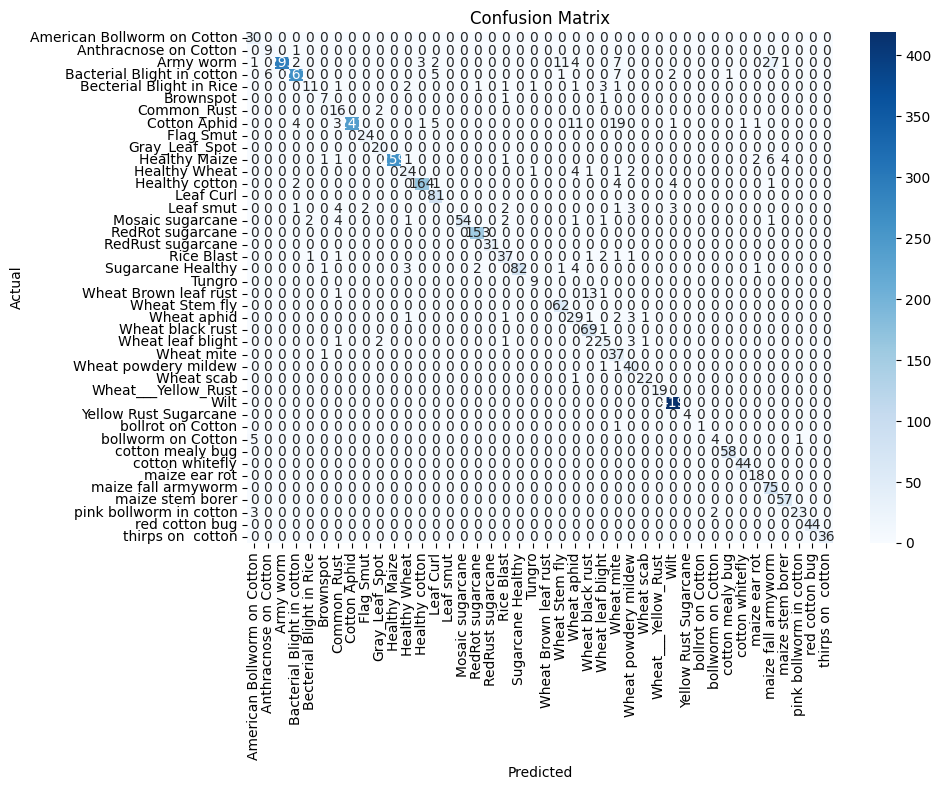

In [11]:
# ------------------ CONFUSION MATRIX ------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [12]:
print(classification_report(y_test, y_pred, target_names=class_map.keys()))

                             precision    recall  f1-score   support

American Bollworm on Cotton       0.77      1.00      0.87        30
      Anthracnose on Cotton       0.60      0.90      0.72        10
                  Army worm       1.00      0.83      0.91       351
 Bacterial Blight in cotton       0.96      0.92      0.94       284
   Becterial Blight in Rice       0.79      0.50      0.61        22
                  Brownspot       0.70      0.78      0.74         9
                Common_Rust       0.50      0.89      0.64        18
               Cotton Aphid       1.00      0.84      0.91       287
                  Flag Smut       0.92      1.00      0.96        24
             Gray_Leaf_Spot       0.83      1.00      0.91        20
              Healthy Maize       1.00      0.94      0.97       275
              Healthy Wheat       0.75      0.73      0.74        33
             Healthy cotton       0.98      0.93      0.95       176
                  Leaf Curl      

/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rahiljain/UTD/Machine_Learning/Project/ML_repo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [13]:
# ------------------ SAVE FEATURES ------------------
print("Saving features and labels...")
np.save('test_features_train.npy', features_train)
np.save('test_features_test.npy', features_test)
np.save('test_y_train.npy', y_train)
np.save('test_y_test.npy', y_test)

# ------------------ SAVE SVM MODEL ------------------
print("Saving SVM model...")
import joblib
joblib.dump(svm, 'test_svm_model.pkl')

# ------------------ SAVE CLASS MAP ------------------
print("Saving class map...")
import json
with open('test_class_map.json', 'w') as f:
    json.dump(class_map, f)

print("All components saved successfully.")


Saving features and labels...
Saving SVM model...
Saving class map...
All components saved successfully.
